# VQ-VAE2 stages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import datasets, transforms, utils

In [ ]:
from forgebox.ftorch.tracker import FG

In [4]:
fg = FG("vqvae2")

==========hyper params==========
{}


### Load Data


In [5]:
from pathlib import Path
from forgebox.ftorch.prepro import test_DS
from torchvision.datasets import ImageFolder
from torchvision import transforms as ts

DATA = Path("/data/disk3/data/imdb_crop/")
SIZE = 256

transforms = ts.Compose([ts.Resize(SIZE),
                         ts.CenterCrop(SIZE),
                         ts.ToTensor(),
                         ts.Normalize([.5,.5,.5,],[.5,.5,.5,])])

ds = ImageFolder(DATA, transform=transforms,)

In [6]:
img,lbl = test_DS(ds)()

In [7]:
img.size(),img.max(),img.min()

(torch.Size([1, 3, 256, 256]), tensor(1.), tensor(-1.))

### Model Structure

In [8]:
CUDA = torch.cuda.is_available()
LR = 3e-4
LATENT_LOSS_WEGIHT = .25
SAMPLE_SIZE = 25

In [9]:
class Quantize(nn.Module):
    """
    VQ embedding
    emb = Quantize(dim, n_embed, decay=0.99,eps=1e-5)
    ### set it to trainable, the training does not SGD
    emb.training = True
    """
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps
        
        # not initialized as a common embedding module
        embed = torch.randn(dim, n_embed)
        # register_buffer: tensors will be in state_dict, but not learnable weights/ variable
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim) # (leng_id, hidden)
        dist = (
            flatten.pow(2).sum(1, keepdim=True) - 2*flatten @ self.embed+ self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype) # (leng_id,leng_id,num_embedding)
        
        # deflatten to original input shape, 
        # except the last dimension
        embed_ind = embed_ind.view(*input.shape[:-1]) 
        quantize = self.embed_code(embed_ind)

        if self.training:
            # update embedding
            # self.cluster_size: how many times has 1 category idx happend
            # (1-decay) for the portion of most recent batch
            # cluster_size * decay + [(1-decay)* category_idx_frequency]
            self.cluster_size.data.mul_(self.decay).add_(
                1 - self.decay, embed_onehot.sum(0)
            )
            # (dim,leng_id) @ (leng_id,num_embedding)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot #(dim, num_embedding)
            
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            # calculate normalization
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)
        
        # latent loss
        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))

In [10]:
# ## Testing the shape 
# emb = torch.rand(50,100) # hidden, num_embedding (order not like usual embedding module)
# flatten = torch.rand(30,50)

# _,emb_id = (-(flatten.pow(2).sum(1,keepdim=True)-2*flatten@emb - emb.pow(2).sum(0, keepdim=True))).max(1)

# print(emb_id)
# emb_onehot = F.one_hot(emb_id,100).type(flatten.dtype)
# print(emb_onehot.size())
# print(emb_onehot.sum(0))# frequency count

# flatten.transpose(0,1)@emb_onehot


In [11]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()
        self.conv = nn.Sequential(*[
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channel, channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, kernel_size=1),
        ])

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out

* Bottom (32 * 32): More Structure Codes
* Top (64 * 64): More Fine Grained Codes

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()
        # downsampling by the scale = 2, twice
        # for encoding bottom , 64*64
        if stride == 4: 
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]
            
        # FURTHER downsampling by the scale = 2, once
        # for encoding top 32*32
        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            # n resblocks, channel in  = channel out
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [13]:
class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [14]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,channel=128,
        n_res_block=2,n_res_channel=32,
        embed_dim=64,n_embed=512,
        decay=0.99,
    ):
        super().__init__()
        
        # bottom encoder
        # downsample by 4x
        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        # top encoder
        # down sample by 2x
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim, #1024
            in_channel,#3
            channel,#128
            n_res_block,# 2
            n_res_channel, # 32
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input) # downsample 4x (bs,channel,sz//4,sz//4)
        enc_t = self.enc_t(enc_b) # downsample 2x again  (bs,channel,sz//8,sz//8)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [15]:
model = VQVAE()

In [16]:
crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = None

In [17]:
if CUDA:
    model.cuda()

### Step 1 Train VQVAE

In [18]:
IMG1 =  fg.taskdir/"stage1_img"

In [19]:
! mkdir -p {IMG1}

In [20]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

In [21]:
t = Trainer(ds, batch_size=64,shuffle=True, num_workers=4, callbacks=[stat])

In [24]:
@t.step_train
def train(batch):
    opt.zero_grad()
    model.train()
    
    img,lbl = batch.data
    if CUDA: img = img.cuda()
        
    out, latent_loss = model(img)
    
    # loss combination
    recon_loss = crit(out,img)
    latent_loss = latent_loss.mean()
    loss = recon_loss + latent_loss * LATENT_LOSS_WEGIHT
    
    # optimization
    loss.backward()
    opt.step()
    if batch.i%199 == 0:
        sample  = img[:SAMPLE_SIZE]
        with torch.no_grad():
            out, _ = model(sample)
        # stack and sample image
        utils.save_image(
            torch.cat([sample,out],0),
            IMG1/('e%s_i%s.png'%(str(batch.epoch+1).zfill(5),str(batch.i).zfill(6))),
            nrow = SAMPLE_SIZE, # rows stacked horizontally
            normalize = True,
            range =(-1,1)
        )
        torch.save(model.state_dict(),fg.taskdir/"model_v1.npy")
    
    return {"recon":recon_loss.item(),
            "latent":latent_loss.item(),
            "loss":loss.item(),
            "lr":opt.param_groups[0]['lr']
           }

In [25]:
t.train(1)

epoch    iter    latent      loss      lr     recon    timestamp
mean    0.0  3599.0  0.039565  0.023649  0.0003  0.013758     0.736537
min     0.0     0.0  0.001020  0.002198  0.0003  0.001811     0.000000
max     0.0  7198.0  0.873575  0.347869  0.0003  0.333287  5302.332554

 [1:35:41<00:52, 4.98it/s, latent=0.00265, loss=0.00207, lr=0.0003, recon=0.00141]

In [26]:
t.train(1)

epoch    iter    latent      loss      lr     recon    timestamp
mean    0.0  3599.0  0.001898  0.002528  0.0003  0.002053     0.737718
min     0.0     0.0  0.001277  0.001413  0.0003  0.001050     0.000000
max     0.0  7198.0  0.008349  0.019168  0.0003  0.018313  5310.828841

In [67]:
# Save model
# torch.save(model.state_dict(),fg.taskdir/"model_v1.npy")

In [ ]:
# Load Model
model.load_state_dict(torch.load(fg.taskdir/"model_v1.npy"))

In [47]:
from PIL import Image

In [ ]:
"/home/hadoop/data/vqvae2/stage1_img/e00001_i007164.png"

2019-07-12 12:08:03,449:DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
2019-07-12 12:08:03,451:DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


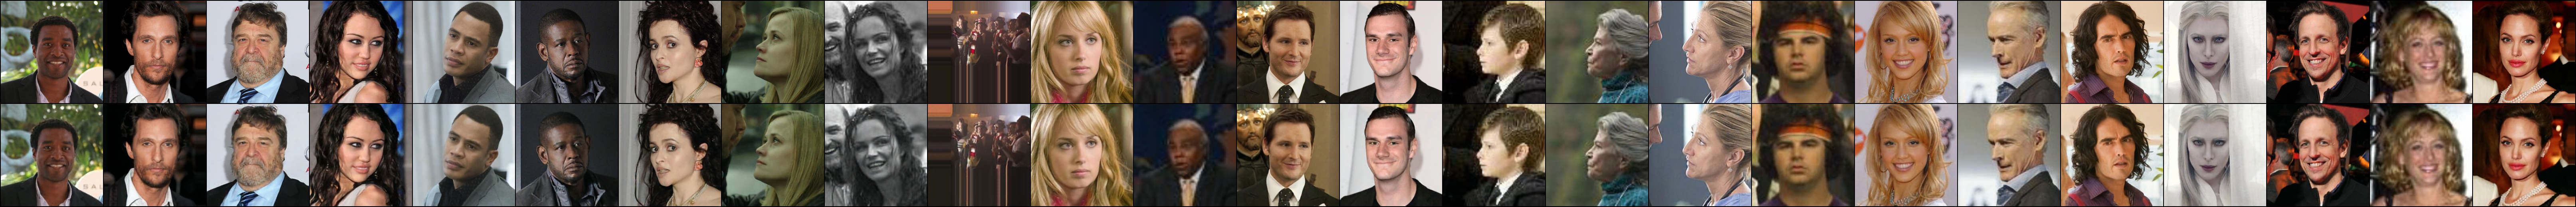

In [48]:
Image.open(fg.taskdir/"stage1_img"/"e00001_i007164.png")

### Step2 Extract Code

Save the discrete code to bcolz array

In [33]:
import bcolz
import numpy as np

In [40]:
ARRAY_DATA = Path("/mnt/disk3/array")

In [41]:
bc_t = bcolz.carray(np.zeros((0,32,32)), rootdir = ARRAY_DATA/"vqvae"/"bc_t")
bc_b = bcolz.carray(np.zeros((0,64,64)), rootdir = ARRAY_DATA/"vqvae"/"bc_b")

In [42]:
ec = Trainer(ds,batch_size=64, shuffle=False,num_workers=4, callbacks=[stat])

In [ ]:
model.eval()

In [45]:
@ec.step_train
def train(batch):
    img,_ = batch.data
    if CUDA: img = img.cuda()
        
    quant_t, quant_b, diff, id_t, id_b = model.encode(img.cuda())
    
    id_t = id_t.detach()
    id_b = id_b.detach()
    
    if CUDA:
        id_t = id_t.cpu()
        id_b = id_b.cpu()
        
    bc_t.append(id_t.numpy())
    bc_b.append(id_b.numpy())
    
    bc_t.flush()
    bc_b.flush()
    return {"size":bc_t.shape[0]}

In [46]:
ec.train(1)

epoch    iter           size    timestamp
mean    0.0  3599.0  230399.998194     0.242137
min     0.0     0.0      64.000000     0.000000
max     0.0  7198.0  460723.000000  1743.143924